In [1]:
# This is just to adjust the width of the notebook to 'Full Screen'
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
%matplotlib notebook

In [3]:
import sys
sys.path.append("/home/pnowack/tigramite")
import matplotlib.ticker as mticker
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import scipy.ndimage
from cartopy.util import add_cyclic_point
import numpy.ma as ma
import cartopy.crs as ccrs
import tigramite
import tigramite.plotting as tp
import pylab
import pylab as pl
import cPickle
import numpy as np
import matplotlib.pyplot as plt
from tigramite.pcmci import PCMCI 
from tigramite.independence_tests import ParCorr
from tigramite.plotting import plot_graph
import tigramite.data_processing as pp
from tigramite.models import LinearMediation
import sklearn
import sklearn.metrics
import scipy
import pandas as pd
import statsmodels
from statsmodels.sandbox.stats import multicomp
import cartopy
from shapely.geometry.polygon import LinearRing
# from models import *
import seaborn as sns
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
from matplotlib import rcParams
import netCDF4
import scipy.stats as stats
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV #gridsearchCV(model, cv) cv for cross validation
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso #gives fewer coeffs than ridge, kinda does feature selection
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler

Could not import packages for CMIknn and GPDC estimation
Could not import r-package RCIT
Could not import r-package acepack for GPACE, use python ACE package
Could not import python ACE package for GPACE


### Supporting functions used to help shape, weigh, and select data

In [4]:
def unpack_ts(y, lon, lat):
    '''
    y should be 3d arrays with same shapes as stemp or precip
    lon and lat are 1d arrays with the desired longitudes and latitudes which may be discontinuous
    returns y for a selected region as defined by lon and lat
    '''
    unpacked = []
    for i in lon:
        dummy = []
        for j in lat:
            dummy.append(y[:,j,i])
        unpacked.append(dummy)
    return np.transpose(unpacked)
          
#check if unpack_ts() works 
# print(unpack_ts(stemp, lon_Europe, lat_Europe).shape)
# print(unpack_ts(stemp, range(192), range(94)).shape)
# print(stemp.shape)
# print(unpack_ts(stemp, lon_Europe, lat_Europe) - stemp[:, 9:27, :17])
# print(stemp-unpack_ts(stemp, range(192), range(94)))

In [5]:
def spacial_weighted_av(y):
    '''
    y should be 3d array with the same format as stemp or precip
    scales point weightings according to latitude using cos(lat)
    accounts for grid points closer to poles being closer together
    returns spacially weighted average
    '''
    y = np.transpose(np.mean(y, axis=(2)))
    weights = np.cos(np.radians(surface_temperature_file['Y'][:][lat_Europe]))
    assert (len(y) == len(weights)), 'Input length in latitude different from lat_now, check if lat_now used is correct' #otherwise really worrying if this comes up
    weighted_y = [y[i] * weights[i] for i in range(len(weights))]
    return np.average(weighted_y, axis=(0))
        
# y = unpack_ts(stemp, lon_Europe, lat_Europe)
# shape(spacial_weighted_av(y))

In [6]:
def select_DJF(y, n=0):
    '''
    y is the input precip or stemp data
    i is the number of years from the last leap year, default i=0 if data starts on leap year
    '''
    assert (len(y) == 25568), 'Number of time steps is not 25568, check correct historical dataset is being used'
    D = 31
    J = 31
    DJF_index = []
    t_days = 0
    leap_count = 0
    while True:
        if n == 0:
            F = 29
            days = 366
            leap_count+=1
        else:
            F = 28
            days = 365
        n+=1
        if n == 4:
            n = 0
        DJF_index += [i for i in range(t_days, t_days + J)] + [j for j in range(t_days + J, t_days + J + F)] + [k for k in range(t_days + (days - D), t_days + days)]
        t_days += days
        if DJF_index[-1] >= 25567:
            break
    assert (DJF_index[-1] == 25567), 'Something went wrong when constructing required indices for DJF data'
    return np.array([y[a] for a in DJF_index])

# print(select_DJF(data_ts[:, 0].reshape(-1,1)).shape)
# print(select_DJF(stemp).shape)

In [7]:
color_dict= {
    'HadGEM2-CC': '#800000',
    'ACCESS1-3': '#9A6324',
    'MIROC5': '#808000',
    'MIROC-ESM': '#469990',
    'HadGEM2-ES': '#000075',
    'BCC-CSM1-1': '#e6194B',
    'BCC-CSM1-1-m': '#f58231',
    'CanESM2': '#ffe119',
    'GISS-E2-R': '#bfef45',
    'MRI-CGCM3': '#3cb44b',
    'MPI-ESM-LR': '#42d4f4',
    'MPI-ESM-MR': '#4363d8',
    'EC-EARTH': '#911eb4',
    'GFDL-CM3': '#f032e6',
    'NCEP': '#000000',
    'IPSL-CM5A-LR': '#a9a9a9',
    'IPSL-CM5A-MR': '#fabebe',
    'CSIRO-Mk3-6-0': '#ffd8b1',
    'CCSM4': '#aaffc3',
    'NorESM1-M': '#ff5733',
    'CNRM-CM5': '#e6beff',
    'ERA': '#000000',
}


### Set up data to be loaded, selecting DJF data here

In [8]:
### this cell might take some time to evaluate
### we focus on DJF first, to look at JJA components you could for example select [6,7,8] for months
months=[12,1,2]
### we have up to 100 components
n_comps=100
### over 70 years
length=70
### this just points to a folder with the PCA Varimax data
plot_load_folder = '/rds/general/project/nowack_graven/live/MSci19/varimax_data'
### you just focus on SLP data from ncar now
model_name= [
    'SLP_ncar_01-01-1948_31-12-2017_detrend.nc'
]
plt.rcParams['xtick.labelsize'] = 7
plt.rcParams['ytick.labelsize'] = 7
### we load the file containing the data
### each principal component is associated with some time dependent weights, indicating how important 
### they are at a given time
### (these are the time series you use later as X)
### and spatial loadings, which show where these 'modes of variability' are located.
### Below we select the centres of the spatial loadings and plot them on a map for 50 selected components
### the indices for these components are given in the csv file below read into comps_order_file
varimax_file=cPickle.load(open(plot_load_folder + '/'+'varimax_%s_3dm_comps-%d_months-%s.bin' % (model_name[0], n_comps, months), 'r'))
comps_order_file=pd.DataFrame.from_csv(plot_load_folder+'/selected_comps_NCEP2_djf.csv')
selected_components=[]
for i in range(1,51):
    selected_components.append('c'+str(i))
#print(selected_components)

selected_comps_indices=[]
for i in selected_components:
    selected_comps_indices.append(int(comps_order_file['comps'][i]))

#print(selected_comps_indices)

d = varimax_file['results']
data_ts = d['ts_unmasked']
data_ts_df = pd.DataFrame(data_ts[:,selected_comps_indices])

# Normalise PCs
dummy_data_ts = []
for column in data_ts_df:
    dummy_data_ts.append(np.divide(data_ts_df[column], max(abs(data_ts_df[column]))))
data_ts_df = pd.DataFrame(select_DJF(np.array(dummy_data_ts).T))
print(data_ts_df.shape)

(6318, 50)


### Add in seasonality

In [9]:
seasonality = lambda x: np.sin(x*2*np.pi/365.25)
pc_season_DJF = select_DJF([seasonality(day) for day in range(25568)])
data_ts_df[50] = pd.DataFrame(pc_season_DJF)
print(data_ts_df.shape)

# print(pd.DataFrame(pc_season_DJF))

(6318, 51)


In [10]:
data_ts_df.shape

(6318, 51)

In [11]:
pc_nlag = data_ts_df.copy()
pc_lag = data_ts_df.copy()

# add lag to time series
for col in pc_lag.columns:
    pc_lag[str(col)+' lag 1']=pc_lag[col].shift(1)
    pc_lag[str(col)+' lag 2']=pc_lag[col].shift(2)
    pc_lag[str(col)+' lag 3']=pc_lag[col].shift(3)
    pc_lag[str(col)+' lag 4']=pc_lag[col].shift(4)
    pc_lag[str(col)+' lag 5']=pc_lag[col].shift(5)
    pc_lag[str(col)+' lag 6']=pc_lag[col].shift(6)
    pc_lag[str(col)+' lag 7']=pc_lag[col].shift(7)
    pc_lag[str(col)+' lag 8']=pc_lag[col].shift(8)
    pc_lag[str(col)+' lag 9']=pc_lag[col].shift(9)
    pc_lag[str(col)+' lag 10']=pc_lag[col].shift(10)

print(pc_lag.shape)

(6318, 561)


In [12]:
#### Let's load temperature and precipitation rate data from the NCAR reanalysis as well
surface_temperature_file = netCDF4.Dataset('/rds/general/project/nowack_graven/live/MSci19/NCEP_NCAR_surface_temperature_1948_2017.nc')
precip_file = netCDF4.Dataset('/rds/general/project/nowack_graven/live/MSci19/NCEP_NCARI_precip_rate_1948_2017.nc')
slp_file = netCDF4.Dataset('/rds/general/project/nowack_graven/live/MSci19/SLP_ncar_01-01-1948_31-12-2017.nc')

In [118]:
stemp = surface_temperature_file['temp'][:,:,:]
precip = precip_file['prate'][:,:,:]*86400 #86000 changes into pricip rate of mm per day
slp = slp_file['slp'][:,:,:]

stemp_mean = np.mean(stemp,axis=0)
precip_mean = np.mean(precip,axis=0)
precip_t_mean_djf = np.mean(select_DJF(precip), axis = 0)
slp_s_mean = np.mean(np.mean(slp, axis = 2), axis = 1) # spatial average
slp_t_mean = np.mean(slp,axis=0) # temporal average

print(stemp.shape, precip.shape, slp.shape)
print(slp_s_mean.shape, slp_t_mean.shape)

((25568, 94, 192), (25568, 94, 192), (25568, 73, 144))
((25568,), (73, 144))


### Define which region to predict

In [14]:
# use this if using (lon, lat) == (94, 192), i.e. precip or stemp
lat_Europe = range(9,27)
lon_Europe = range(17)

# use this if (lon, lat) == (73,144), i.e. slp
# lat_Europe = range(9,22)
# lon_Europe = range(15)

### Set up X and Y variables for ML

In [15]:
X50 = pc_nlag
X550 = pc_lag

climate_variable_dict = {'precip':precip, 'stemp':stemp, 'slp':slp}

v_pred = 'precip' # variable to predict using X
Y = unpack_ts(select_DJF(climate_variable_dict[v_pred]), lon_Europe, lat_Europe)
if v_pred == 'precip' or v_pred == 'stemp':
    lon = precip_file['X'][:]
    lat = precip_file['Y'][:]
elif v_pred == 'slp':
    lon = slp_file['lon'][:]
    lat = slp_file['lat'][:]
else:
    raise Exception('Check if v_pred is set correctly')
    
print(Y.shape)
Y = Y.reshape((6318,len(lon_Europe) * len(lat_Europe)))
print(Y.shape)

# define Y_av, spacially weighted average Y, to use to find best estimator
# Y_av = spacial_weighted_av(Y)

(6318, 18, 17)
(6318, 306)


### Split data into training and testing sets

In [16]:
### see function https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html
# dont want to shuffle data 
X50_train, X50_test = train_test_split(X50[10:], test_size=0.25, shuffle=False)
X550_train, X550_test = train_test_split(X550[10:], test_size=0.25, shuffle=False)
Y_train, Y_test = train_test_split(Y[10:], test_size=0.25, shuffle=False)
# Y_av_train, Y_av_test = train_test_split(Y_av[10:], test_size=0.25, shuffle=False)

# Y is a multi dimensional array, but train_test_split gives us the split data along the time axis (0)
print(Y_train.shape, Y_test.shape)

((4731, 306), (1577, 306))


In [17]:
cv_obj = TimeSeriesSplit(n_splits=4) #make 4 splits -> 5 data sets

### Machine learning

In [18]:
alpha_i=[0.03,0.1,0.3,1,10,30,60,100,300,600,1000,3000,6000,10000,30000,1e5,3e5,1e6,3e6]#,1e7,3e7,8e7,1e8,3e8,8e8]
parameters_Ridge = {
    'alpha': alpha_i,
    'fit_intercept': [False,True],
    'max_iter':[1000],
    'random_state':[100]
             }

### The alphas we get here seem to be abnormally small?

In [19]:
# %%time

# ridge50 = GridSearchCV(Ridge(),parameters_Ridge, cv=cv_obj, n_jobs=-1, refit=True) #n_jobs takes max num of CPUs available if -1, refit 
# ridge50.fit(X50_train, Y_train)
# # Y_pred = ridge50.best_estimator_.predict(X50_test)
# # Y_pred_train = ridge50.best_estimator_.predict(X50_train)
# print(ridge50.best_estimator_)

# ridge550 = GridSearchCV(Ridge(),parameters_Ridge, cv=cv_obj, n_jobs=-1, refit=True) #n_jobs takes max num of CPUs available if -1, refit 
# ridge550.fit(X550_train, Y_train)
# # Y_pred = ridge550.best_estimator_.predict(X550_test)
# # Y_pred_train = ridge550.best_estimator_.predict(X550_train)
# print(ridge550.best_estimator_)

In [20]:
# ridge_coefs_nl = abs(regr50.best_estimator_.coef_)
# ridge_coefs_l = abs(regr550.best_estimator_.coef_)
# features_list = list(data_ts_df.columns)

In [21]:
def abs_normalize(c):
    """
    First convert all values in input c into positive values
    Then scale all values in the input array with the same coefficient so they sum to 1
    """
    c_abs = np.array([abs(i) for i in c])
    s = sum(c_abs)
    return np.array([j/s for j in c_abs])

Need to do something similar to this
```python
for y in Y[:,lon,lat]:
    ridge(X, y)
```

In [27]:
feature_name_list550 = X550.columns
feature_name_list50 = X50.columns

ridge550 = Ridge(alpha = 300, 
                 copy_X = True, 
                 fit_intercept = True, 
                 max_iter = 1000,
                 normalize = False,
                 random_state = 100, 
                 solver = 'auto', 
                 tol = 0.001)



ridge50 = Ridge(alpha = 30, 
                copy_X = True, 
                fit_intercept = True, 
                max_iter = 1000,
                normalize = False, 
                random_state = 100, 
                solver = 'auto', 
                tol = 0.001)

# As a reminder:
# lat_Europe = range(9,27)
# lon_Europe = range(17)

corr_50 = []
corr_550 = []
coefs_50 = []
coefs_550 = []

for i in range(len(Y_train.T)):
    Yu_train = Y_train[:,i]
    ridge50.fit(X50_train, Yu_train)
    normalized_importance_ridge50 = abs_normalize(ridge50.coef_)
    Y_pred = ridge50.predict(X50_test)
#     print('corr: %s' %(np.corrcoef(Y_pred, Y_test[:,i])[0,1]))
    corr_50.append(np.corrcoef(Y_pred, Y_test[:,i])[0,1])
    coefs_50.append(ridge50.coef_)
    
for i in range(len(Y_train.T)):
    Yu_train = Y_train[:,i]
    ridge550.fit(X550_train, Yu_train)
    normalized_importance_ridge550 = abs_normalize(ridge550.coef_)
    Y_pred = ridge550.predict(X550_test)
#     print('corr: %s' %(np.corrcoef(Y_pred, Y_test[:,i])[0,1]))
    corr_550.append(np.corrcoef(Y_pred, Y_test[:,i])[0,1])
    coefs_550.append(ridge550.coef_)
    
# Lasso550 = linear_model.Ridge(alpha=0.07)
# Lasso550.fit(X550_train[10:],Y_train[10:])

# Lasso50 = linear_model.Ridge(alpha=0.05)
# Lasso50.fit(X50_train[10:],Y_train[10:])


# normalized_importance_Lasso550=norm_imp(Lasso550.coef_)
# normalized_importance_Lasso50=norm_imp(Lasso50.coef_)

def extract_feature_lag(l):
    """
    Used to separate feature and lag from a list of features in the form of e.g. '17 lag 3'
    Takes a list of str and/or int
    Returns list of feature labels (str) and corresponding lags (int)
    """
    lag = []
    feature = []
    for i in l:
        if type(i) == int:
            feature.append(str(i))
            lag.append(0)
        elif type(i) == str:
            i_s = i.split()
            feature.append(i_s[0])
            lag.append(i_s[-1])
        else:
            raise TypeError('Unsupported type %s, must be int or str' %(type(i)))
    return feature, lag
    
fea_list550, lag_list550 = extract_feature_lag(feature_name_list550)
fea_list50, lag_list50 = extract_feature_lag(feature_name_list50) # yes, I know this is unnecessary, I just want consistency to make lives easier later

importance_ridge550 = sum([np.array(i) for i in coefs_550])
importance_ridge50 = sum([np.array(i) for i in coefs_50])

normalized_importance_ridge550 = abs_normalize(sum([np.array(i) for i in coefs_550]))
normalized_importance_ridge50 = abs_normalize(sum([np.array(i) for i in coefs_50]))

fea_550_sign = [np.divide(i, abs(i)) for i in ridge550.coef_]
fea_50_sign = [np.divide(i, abs(i)) for i in ridge50.coef_]

# fea_imp_ridge550 = pd.DataFrame({'name': list(feature_name_list550),
#                                  'feature': fea_list550,
#                                  'lag': lag_list550,
#                                  'importance': normalized_importance_ridge550, 
#                                  'sign': fea_550_sign }).sort_values('importance', ascending = False)
# fea_imp_ridge50 = pd.DataFrame({'name': list(feature_name_list50),
#                                  'feature': fea_list50,
#                                  'lag': lag_list50,
#                                  'importance':normalized_importance_ridge50,
#                                  'sign': fea_50_sign }).sort_values('importance', ascending = False)
# fea_imp_Lasso550 = pd.DataFrame({'feature': list(feature_name_list550),
#                         'importance':normalized_importance_Lasso550 }).sort_values('importance', ascending = False)
# fea_imp_Lasso50 = pd.DataFrame({'feature': list(feature_name_list50),
#                         'importance':normalized_importance_Lasso50 }).sort_values('importance', ascending = False)

In [61]:
fea_imp_ridge550 = pd.DataFrame({'name': list(feature_name_list550),
                                 'feature': fea_list550,
                                 'lag': lag_list550,
                                 'n_importance': normalized_importance_ridge550,
                                 'importance': importance_ridge550,
                                 'sign': fea_550_sign }).sort_values('n_importance', ascending = False)
fea_imp_ridge50 = pd.DataFrame({'name': list(feature_name_list50),
                                 'feature': fea_list50,
                                 'lag': lag_list50,
                                 'n_importance':normalized_importance_ridge50,
                                 'importance': importance_ridge50,
                                 'sign': fea_50_sign }).sort_values('n_importance', ascending = False)

In [62]:
# ridge features (coefficients) and their scaled importances (values) sorted by importance
# print(fea_imp_ridge550)
# df_1 = fea_imp_ridge550.reset_index()

In [63]:
# print(normalized_importance_ridge550.shape)
# print(np.array(coefs_550).shape)
# print(np.array(corr_50).shape)
print(fea_imp_ridge550)

    feature  importance lag  n_importance       name  sign
28       28  -76.692376   0      0.023168         28  -1.0
24       24   67.592158   0      0.020419         24   1.0
27       27   58.751587   0      0.017748         27   1.0
17       17  -57.315225   0      0.017314         17  -1.0
26       26   56.104701   0      0.016948         26  -1.0
46       46  -46.217070   0      0.013961         46   1.0
221      17  -44.261861   1      0.013371   17 lag 1  -1.0
311      26   41.474298   1      0.012529   26 lag 1   1.0
50       50  -40.897415   0      0.012354         50   1.0
25       25   37.425176   0      0.011306         25   1.0
291      24   37.004233   1      0.011178   24 lag 1   1.0
222      17  -29.854337   2      0.009019   17 lag 2  -1.0
551      50  -26.616600   1      0.008040   50 lag 1   1.0
232      18  -26.436540   2      0.007986   18 lag 2  -1.0
463      41  -24.554838   3      0.007418   41 lag 3  -1.0
293      24   23.583490   3      0.007124   24 lag 3   1

### Data visualisation and processing

In [64]:
corr_50_3d = np.array(corr_50).reshape(len(lat_Europe), len(lon_Europe))
corr_550_3d = np.array(corr_550).reshape(len(lat_Europe), len(lon_Europe))
print(corr_550_3d.shape)

(18, 17)


Populating the interactive namespace from numpy and matplotlib
('Number of levels: ', 11)
[71.42619 69.52167 67.6171  65.71251 63.8079  61.90326 59.99861 58.09395
 56.18928 54.28461 52.37991 50.47522 48.57052 46.66582 44.76111 42.8564
 40.95169 39.04697] lat Europe
[ 0.     1.875  3.75   5.625  7.5    9.375 11.25  13.125 15.    16.875
 18.75  20.625 22.5   24.375 26.25  28.125 30.   ] lon Europe


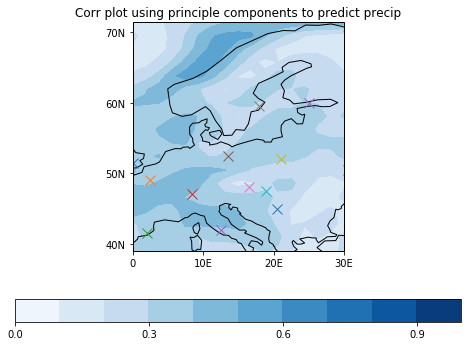

('Number of levels: ', 11)
[71.42619 69.52167 67.6171  65.71251 63.8079  61.90326 59.99861 58.09395
 56.18928 54.28461 52.37991 50.47522 48.57052 46.66582 44.76111 42.8564
 40.95169 39.04697] lat Europe
[ 0.     1.875  3.75   5.625  7.5    9.375 11.25  13.125 15.    16.875
 18.75  20.625 22.5   24.375 26.25  28.125 30.   ] lon Europe


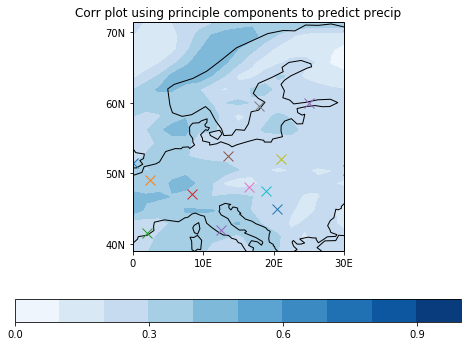

In [65]:
%pylab inline

def corr_visualise(corr, save = None, pred = v_pred):
    fig=plt.figure(figsize = (8,6))
#     fig=plt.figure()
    import matplotlib.colors as colors
    from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
    from shapely.geometry.polygon import LinearRing

#     pylab.rcParams['figure.figsize'] = (100, 50)
    # ax = plt.axes(projection=ccrs.PlateCarree())
    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.set_title('Corr plot using principle components to predict %s' %(pred))
    ax.set_aspect(1.0)
    rc('text', usetex=False)
    ax.coastlines()
    levels = np.arange(0,1.1,0.1)
    print('Number of levels: ', len(levels))

    # plot correlation coef here
    im=ax.contourf(lon[lon_Europe], lat[lat_Europe], corr, cmap='Blues', levels = levels)

    ax.set_xticks([0, 10, 20, 30],crs=ccrs.PlateCarree())
    ax.set_yticks([30, 40, 50, 60, 70],crs=ccrs.PlateCarree())
    ax.set_yticklabels(['30N','40N','50N','60N', '70N'],size=10)
    ax.set_xticklabels(['0','10E','20E','30E'],size=10)

    print lat[lat_Europe],'lat Europe'
    print lon[lon_Europe],'lon Europe'
    lat_begin=lat[lat_Europe[0]]
    lat_end=lat[lat_Europe[-1]]
    lon_begin=lon[lon_Europe[0]]
    lon_end=lon[lon_Europe[-1]]
    lats_ring = [lat_end, lat_end, lat_begin, lat_begin]
    # print lats_ring
    lons_ring = [lon_begin, lon_end, lon_end, lon_begin]
    ring = LinearRing(list(zip(lons_ring, lats_ring)))
    # ax.add_geometries([ring], ccrs.PlateCarree(), facecolor='none', edgecolor='black',linewidth=3)

    city_grid = {'London':(0, 15), 'Madrid':(-1,20), 'Barcelona':(1, 19), 'Zurich':(3, 17), 'Rome':(5, 19), 'Berlin':(5, 15), 
                 'Vienna':(7, 17), 'Stockholm':(7, 12), 'Warsaw':(8, 15), 'Budapest':(8, 17), 'Belgrade':(8, 18), 
                 'Paris':(1, 16), 'Moscow':(15, 14), 'Kyiv': (12, 16), 'Helsinki':(10, 12)}

    # for i in city_grid.values():
    #     if lon[i[0]] < 180:
    #         pl.plot(lon[i[0]], lat[i[1]], 'o', ms = 3, color = '#000000')
    #     else:
    #         pl.plot(lon[i[0]] - 360, lat[i[1]], 'o', ms = 3, color = '#000000')

    # major european cities
    ms = 10
    pl.plot(0, 51.5, 'x', label = 'London', ms = ms) #[0,6] left to right, top to bottom of lon_Eu and lat_Eu
    pl.plot(-3, 40, 'x', label = 'Madrid', ms = ms) # [-1,11]
    pl.plot(2, 41.5, 'x', label = 'Barcelona', ms = ms) # [1,10]
    pl.plot(8.5, 47, 'x', label = 'Zurich', ms = ms) # [3,8]
    pl.plot(12.5, 42, 'x', label = 'Rome', ms = ms) # [5,10]
    pl.plot(13.5, 52.5, 'x', label = 'Berlin', ms = ms) # [5,6]
    pl.plot(16.5, 48, 'x', label = 'Vienna', ms = ms) # [7,8]
    pl.plot(18, 59.5, 'x', label = 'Stockholm', ms = ms) # [7,3]
    pl.plot(21, 52, 'x', label = 'Warsaw', ms = ms) # [8,6]
    pl.plot(19, 47.5, 'x', label = 'Budapest', ms = ms) # [8,8]
    pl.plot(20.5, 45, 'x', label = 'Belgrade', ms = ms) # [8,9]
    pl.plot(2.5, 49, 'x', label = 'Paris', ms = ms) # [1,7]
    pl.plot(37.5, 55.75, 'x', label = 'Moscow', ms = ms) # [15,5]
    pl.plot(30.5, 50.5, 'x', label = 'Kyiv', ms = ms) # [12,7]
    pl.plot(25, 60, 'x', label = 'Helsinki', ms = ms) # [10,3]

    # plt.savefig('surface_map.pdf',dpi=300)
    pl.xlim(lon_begin, lon_end)
    pl.ylim(lat_end, lat_begin)
    fig.colorbar(im,ax=ax,orientation='horizontal', ticks = levels[::3])
    if save != None:
        pl.savefig(save)
    plt.show()
    
corr_visualise(corr_50_3d, save = 'corr_Europe_precip_nl')
corr_visualise(corr_550_3d, save = 'corr_Europe_precip_l')

# corr_visualise(corr_50_3d)
# corr_visualise(corr_550_3d)

Populating the interactive namespace from numpy and matplotlib


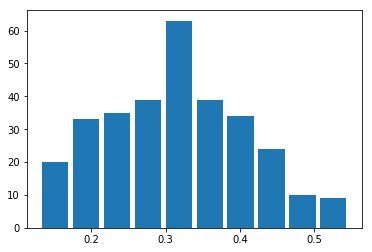

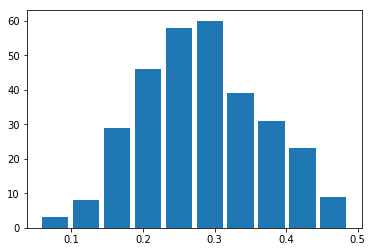

In [67]:
%pylab inline

pl.figure()
pl.hist(corr_50, rwidth = 0.85)
pl.show()

pl.figure()
pl.hist(corr_550, rwidth = 0.85)
pl.show()

In [68]:
def make_ring(ax, lon_v, lat_v, lon_indices, lat_indices, colour = 'black'):
    """
    lon_v and lat_v lists of actual lon and lat values used in conjunction with the lon_indices and lat_indices
    """
    lat_begin=lat_v[lat_indices[0]]
    lat_end=lat_v[lat_indices[-1]]
    lon_begin=lon_v[lon_indices[0]]
    lon_end=lon_v[lon_indices[-1]]
    lats_ring = [lat_end, lat_end, lat_begin, lat_begin]
    #print(lats_ring)
    lons_ring = [lon_begin, lon_end, lon_end, lon_begin]
    ring = LinearRing(list(zip(lons_ring, lats_ring)))
    ax.add_geometries([ring], ccrs.PlateCarree(), facecolor='none', edgecolor=colour, linewidth=3)
    return

In [69]:
def list_duplicates_of(seq, item):
    start_at = -1
    locs = []
    while True:
        try:
            loc = seq.index(item,start_at+1)
        except ValueError:
            break
        else:
            locs.append(loc)
            start_at = loc
    return locs

### Visualises pcs and their signs

('sc: ', ['c29', 'c25', 'c28', 'c18', 'c27', 'c47', 'c18', 'c27', 'c51', 'c26', 'c25', 'c18', 'c51', 'c19', 'c42', 'c25', 'c42', 'c25', 'c19', 'c19'])
('asc:', ['c28', 'c24', 'c27', 'c17', 'c26', 'c46', 'c17', 'c26', 'c50', 'c25', 'c24', 'c17', 'c50', 'c18', 'c41', 'c24', 'c41', 'c24', 'c18', 'c18'])
('used pcs: ', [34, 30, 33, 22, 32, 58, 22, 32, 100, 31, 30, 22, 100, 23, 52, 30, 52, 30, 23, 23])
{32: [0, 1], 33: [0], 34: [0], 100: [0, 1], 52: [3], 22: [0, 1, 2], 23: [2], 58: [0], 30: [0, 1], 31: [0]}
('fimp_u: ', [0.02947707117338779, 0.01774792441020397, -0.02316755287031627, -0.020394915218549164, -0.007417627810724022, -0.039703352471664524, -0.007986060185364985, -0.013961445253484047, 0.03159691414143036, 0.011305553440932559])
('fimp_norm: ', array([-0.02316755,  0.02041852,  0.01774792, -0.01731402,  0.01694834,
       -0.01396145, -0.01337081,  0.01252873, -0.01235446,  0.01130555,
        0.01117839, -0.00901852, -0.00804045, -0.00798606, -0.00741763]))
Contour showing DJF s

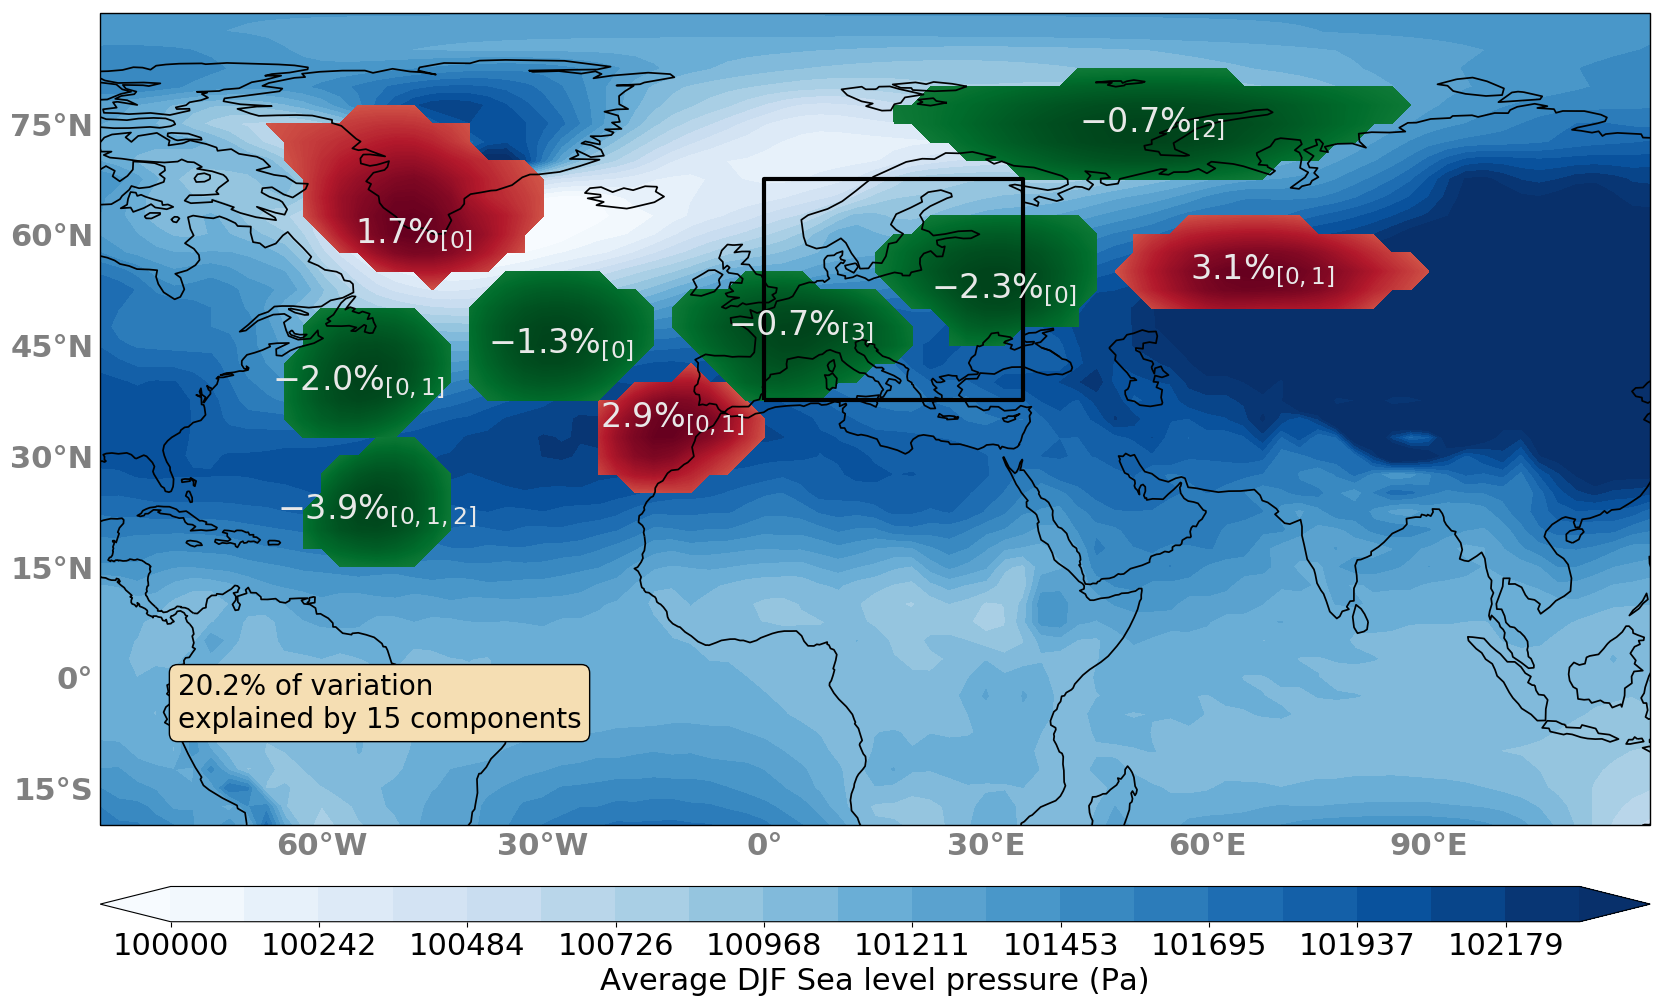

CPU times: user 11.9 s, sys: 188 ms, total: 12.1 s
Wall time: 12.1 s


In [169]:
%%time

def comps_visualise(used_comps, vf, lon_v, lat_v, lon_indices = lon_Europe, lat_indices = lat_Europe, lag = None, signs = None, contour = None, num_f = None, sig = None):
    """
    Used comps should be the labels of the components that we want to plot
        WARNING: The same component may appear multiple times if lag is used
    vf is varimax file used
    lon_v and lat_v lists of actual lon and lat values used in conjunction with the lon_indices and lat_indices
    lag should be a list of int that map to used_comps, default to None so assume no lag is used
    
    -----------below is stuff that still needs implementation------------
    ----------and therefore temporarily banished to the backlog----------
    num_f is the number of features desired
    sig is the variability threshold we want our features to resemble
    ***finish this documentation later***    
    """

    # add 1 to label because 'c1' is actually 'c0' but journal requires label to start at 1
    # this is passed to the comps_order_file
    selected_components=[]
    for i in used_comps:
        selected_components.append('c'+str(int(i)+1))
    print('sc: ', selected_components)

    # these are the 'actual' used components
    actual_selected_components=[]
    for i in used_comps:
        actual_selected_components.append('c'+str(i))
    print('asc:', actual_selected_components)


    sci=[] # selected comps indices
    
    for i in selected_components:
        if i == 'c51':
            sci.append(100)
        else:
            sci.append(int(comps_order_file['comps'][i]))
    print('used pcs: ', sci)

    fimp = fea_imp_ridge550.reset_index()['importance'][:15]
    fimp_total = sum(np.array([abs(f) for f in fea_imp_ridge550.reset_index()['importance']]))
    fimp_norm = np.array(fimp/fimp_total)
#     print(len(fimp_norm))
    
    if lag.any() != None:
        lag_list = [int(i) for i in lag]
#         print('lags: ', lag_list)

        # avoid printing repeated components twice
        comp_lags = {c:[] for c in sci} # linked components and their lags
        fimp_n_group = {c:[] for c in sci}
        for i in zip(sci, lag_list, fimp_norm):
            comp_lags[i[0]].append(i[1])
            fimp_n_group[i[0]].append(i[2])
        print(comp_lags) # unsure why the keys in dict are reshuffled, might be worth looking into later if problems occur
        sci = list(i for i in comp_lags.keys())
        lag = list(comp_lags.values())
        fimp_u = [sum(np.array(i)) for i in np.array(fimp_n_group.values())] # used feature importance
        
#         print('fimp: ', fimp_u)
            
    print('fimp_u: ', fimp_u)
    print('fimp_norm: ', fimp_norm)
    
    d = vf['results']
    data_ts = d['ts_unmasked']
    lons = d['lons']
    lats = d['lats']
    weights = d['weights'].reshape((len(lats), len(lons), n_comps))
#     print(weights.shape)

    fig = plt.figure( figsize=(20, 16))
    pl.rcParams.update(pl.rcParamsDefault)
    font = {'size': 22}
    pl.rc('font', **font)
    
    fac=0.625
    ax = fig.add_subplot(111,projection=ccrs.PlateCarree())
    ax.coastlines(linewidth=1.25)
    ax.set_global()    

    textstr = str(sum(abs(fimp_norm))*100)[:4] + '% of variation\nexplained by 15 components'
    props = dict(boxstyle='round', facecolor='wheat', alpha=1)
    ax.text(0.05, 0.15, 
            textstr, 
            transform=ax.transAxes, 
            fontsize=20,
            verticalalignment='center', 
            bbox=props)
            
    if contour.any() != None:
        wrap_data, wrap_lon = add_cyclic_point(contour, coord=lon_v)
        im = ax.contourf(wrap_lon, 
                    slp_file['lat'][:], 
                    wrap_data, 
                    cmap='Blues', 
                    transform=ccrs.PlateCarree(central_longitude=0.0),
                    levels=np.linspace(100000, 102300, 20), # (np.min(contour), np.max(contour), 15), # change this to modify contour resolution
                    extend = 'both'
                    )
        print('Contour showing DJF slp data')
        fig.colorbar(im,ax=ax,orientation='horizontal', aspect = 40, pad = 0.05, label = 'Average DJF Sea level pressure (Pa)')    
    
    node_pos = d['comps_max_loc']
    j=0
        
    for i in sci:
        if i == 100:
            continue
        vmax=np.amax(weights[:, :, i])
        vmin = -vmax
        step = (vmax)/200.0
        levels=np.arange(vmin,vmax+step,step)
        wrap_data, wrap_lon = add_cyclic_point(weights[:,:,i], coord=lons, axis=1) #wraps data around so connects last and first data points on the sphere
    #     wrap_data = scipy.ndimage.zoom(wrap_data, 3)
        #plots the contours of components
        #lats=np.zeros(len(ma.masked_where(wrap_data<= fac*np.max(wrap_data), wrap_data)))
        if fimp_u[j] > 0 :
            comp_cmap = 'RdBu_r'
            clabel = 'Positive'
        else:
            comp_cmap = 'BuGn'
            clabel = 'Negative'
        ax.contourf(wrap_lon, 
                    lats, 
                    ma.masked_where(wrap_data<= fac*np.max(wrap_data), wrap_data),
                    cmap=plt.get_cmap(comp_cmap), #sets colour fill of the contours
                    vmin = vmin,
                    vmax = vmax,
                    transform=ccrs.PlateCarree(central_longitude=0.0),
                    levels=levels,
                    label = clabel)
#         ax.pcolormesh(wrap_lon, lats, ma.masked_where(wrap_data<= fac*np.max(wrap_data), wrap_data),cmap=plt.get_cmap('RdBu_r'),transform=ccrs.PlateCarree(central_longitude=0.0),vmin=vmax, vmax=vmax+vmax/10.0)
        #xpos and ypos give center of component
        xpos = node_pos['x'][i]
        ypos = node_pos['y'][i]
        if fimp_u[j] < 0:
            digits = 4
        else:
            digits = 3
        plt.text(xpos, ypos, r'$%s_{%s}$' %(str(fimp_u[j]*100)[:digits] + '\%', lag[j]), \
             verticalalignment='center', \
             horizontalalignment='center', \
             transform=ccrs.PlateCarree(),color='#E8E8E8',size=24)
        j+=1
    #     ax.set_title(model_name_dict[model]+', no years: '+str(length),size=20)
    
    make_ring(ax, lon_v, lat_v, lon_indices, lat_indices)
    
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                      linewidth=2, color='gray', alpha=0.5, linestyle='--')
    gl.xlabels_top = False
    gl.ylabels_left = True
    gl.ylabels_right = False
    gl.xlines = False
    gl.ylines = False
    gl.xlocator = mticker.FixedLocator([-180, -150, -120, -90, -60, -30, 0, 30, 60, 90, 120, 150, 180])
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.xlabel_style = {'size': 24, 'color': 'gray', 'weight': 'bold'}
    gl.xlabel_style = {'color': 'gray', 'weight': 'bold'}
    gl.ylabel_style = {'size': 24, 'color': 'gray', 'weight': 'bold'}
    gl.ylabel_style = {'color': 'gray', 'weight': 'bold'}
    pl.xlim(-90, 120)
    pl.ylim(-20,90)
    pl.savefig('comps_eur_precip_variation.png')
    plt.show()
    return

# comps_visualise(ridge_f[:5], 
#                 varimax_file, 
#                 surface_temperature_file['X'][:], 
#                 surface_temperature_file['Y'][:])

comps_visualise(used_comps = fea_imp_ridge550.reset_index()['feature'][:20], 
                vf = varimax_file, 
                lat_indices = range(9,22),
                lon_indices = range(15),
                lon_v = slp_file['lon'][:],
                lat_v = slp_file['lat'][:],
                lag = fea_imp_ridge550.reset_index()['lag'][:20],
                signs = fea_imp_ridge550.reset_index()['sign'][:20],
                contour = np.mean(select_DJF(slp),axis=0))

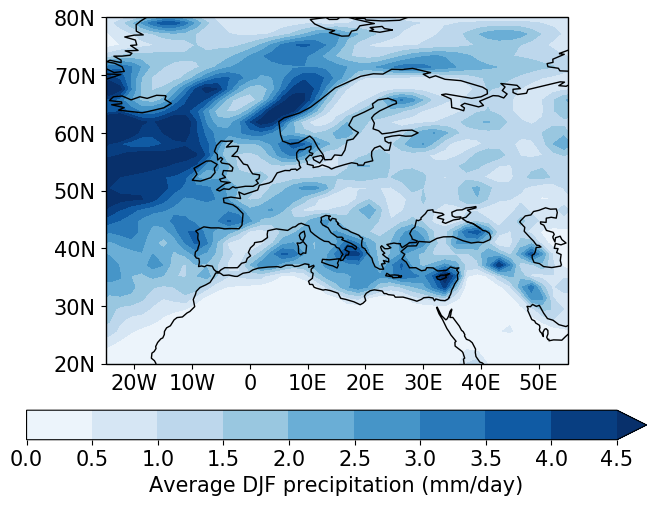

In [170]:
fig=plt.figure(figsize = (8,6))
import matplotlib.colors as colors
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

ax = plt.axes(projection=ccrs.PlateCarree())
# ax.set_title('Corr plot using principle components to predict %s' %(pred))
pl.rcParams.update(pl.rcParamsDefault)
font = {'size': 15}
pl.rc('font', **font)
# ax.set_aspect(1.0)
# rc('text', usetex=False)
wrap_data, wrap_lon = add_cyclic_point(precip_t_mean_djf, coord=lon, axis=1)
ax.coastlines()
levels = np.arange(0,5,0.5)
# print('Number of levels: ', len(levels))

# plot correlation coef here
im=ax.contourf(wrap_lon, lat, wrap_data, cmap='Blues', origin = 'lower', levels = levels, extend = 'max')

fig.colorbar(im, ax=ax, orientation='horizontal', aspect = 20, pad = 0.1, label = 'Average DJF precipitation (mm/day)') 
ax.set_aspect(1.0)

ax.set_xticks([-20,-10, 0, 10, 20, 30, 40, 50],crs=ccrs.PlateCarree())
ax.set_yticks([20, 30, 40, 50, 60, 70, 80],crs=ccrs.PlateCarree())
ax.set_yticklabels(['20N', '30N','40N','50N','60N','70N','80N'],size=15)
ax.set_xticklabels(['20W','10W', '0','10E','20E','30E', '40E','50E'],size=15)

pl.xlim(-25, 55)
pl.ylim(20,80)
pl.savefig('eur_DJF_precip.png')
pl.show()

In [ ]:
### or plot directly the time series. How well does your model perform?
%pylab inline
# Y_pred = ridge50.best_estimator_.predict(X50_test)
fig=plt.figure()
pylab.rcParams['figure.figsize'] = (40, 40)
nt_test = len(Y_test)
plt.plot(np.arange(0,nt_test,1),Y_test,color='k',label='true data',linewidth=2)
plt.plot(np.arange(0,nt_test,1),Y_pred,color='r',label='your predictions',linewidth=2)
#plt.text(0,5.55,'Pearson corrlation coeff: %s \n Mean squared error: %s' %(p_corr_coeff, mean_sq_err))
# plt.savefig("test_8_splits")
plt.show()

### Pearson correlation: 
p_corr_coeff = np.corrcoef(Y_test,Y_pred)[0,1]
print(p_corr_coeff)
### mean squared error
mean_sq_err = mean_squared_error(Y_test,Y_pred)
print(mean_sq_err)

In [ ]:
varimax_file.items()

In [57]:
slp_file.variables

OrderedDict([(u'lon', <type 'netCDF4._netCDF4.Variable'>
              float32 lon(lon)
                  standard_name: longitude
                  long_name: longitude
                  units: degrees_east
                  axis: X
              unlimited dimensions: 
              current shape = (144,)
              filling on, default _FillValue of 9.96920996839e+36 used),
             (u'lat', <type 'netCDF4._netCDF4.Variable'>
              float32 lat(lat)
                  standard_name: latitude
                  long_name: latitude
                  units: degrees_north
                  axis: Y
              unlimited dimensions: 
              current shape = (73,)
              filling on, default _FillValue of 9.96920996839e+36 used),
             (u'time', <type 'netCDF4._netCDF4.Variable'>
              float32 time(time)
                  standard_name: time
                  long_name: Time
                  units: hours since 1800-01-01 00:00:0.0
                  c

In [56]:
ajx = [1,2,3,1,6,3,4]
aajx = np.array(ajx)
# ajx.pop(0)
print(aajx - 1)
for i, j in ajx, ajx:
    print(i,j)

[0 1 2 0 5 2 3]


ValueError: too many values to unpack

In [25]:
ain = np.array([1,2,3])
aint = np.array([2,3,8])
print(sum([ain, aint]))

[ 3  5 11]
